## Ejercicio Time Series Forecast
Para este ejercicio vamos a predecir cuál será la demanda de pasajeros de una aerolinea, para poder anticiparse a las contrataciones de personal, mantenimiento de las aeronaves y gestión de inventario y comidas.

Para ello, se pide:
1. Carga datos (AirPassengers.csv) y representa la serie. ¿Hay seasonality? ¿Cada cuanto?
2. Crea en una gráfica la variable original + su media obtenida mediante una rolling window con el valor de seasonality obtenido en el apartado anterior. Tienes que usar la función rolling() del DataFrame.
3. Comprueba de manera estadística si la serie es o no stationary.
4. Aplica una transformación logarítmica sobre los datos para mejorar el proceso de transformación de tu time series a stationary. Acuérdate después del forecast de invertir la transformación.
5. Divide en train y test. Guarda 20 muestras para test.
6. Crea tu primer modelo ARIMA. Habrá varias combinaciones en función de sus hiperparámetros... Mide el MAE y RMSE del modelo en predicción. Ten en cuenta el parámetro "m" de la función ARIMA, mediante el cual se establece el seasonality.
7. Representa en una gráfica los datos de test y tus predicciones.
8. Prueba un decission tree y un random forest, a ver qué performance presentan.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Carga datos y representa la serie

In [25]:
df = pd.read_csv('data/AirPassengers.csv')
df

,date,value
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121
...,...,...
139,1960-08-01,606
140,1960-09-01,508
141,1960-10-01,461
142,1960-11-01,390


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    144 non-null    object
 1   value   144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [26]:
df['date'] = pd.to_datetime(df['date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    144 non-null    datetime64[ns]
 1   value   144 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.4 KB


In [10]:
df['date'].dt.freq

'MS'

In [12]:
pd.date_range(df['date'].min(), df['date'].max(), freq="MS")

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', length=144, freq='MS')

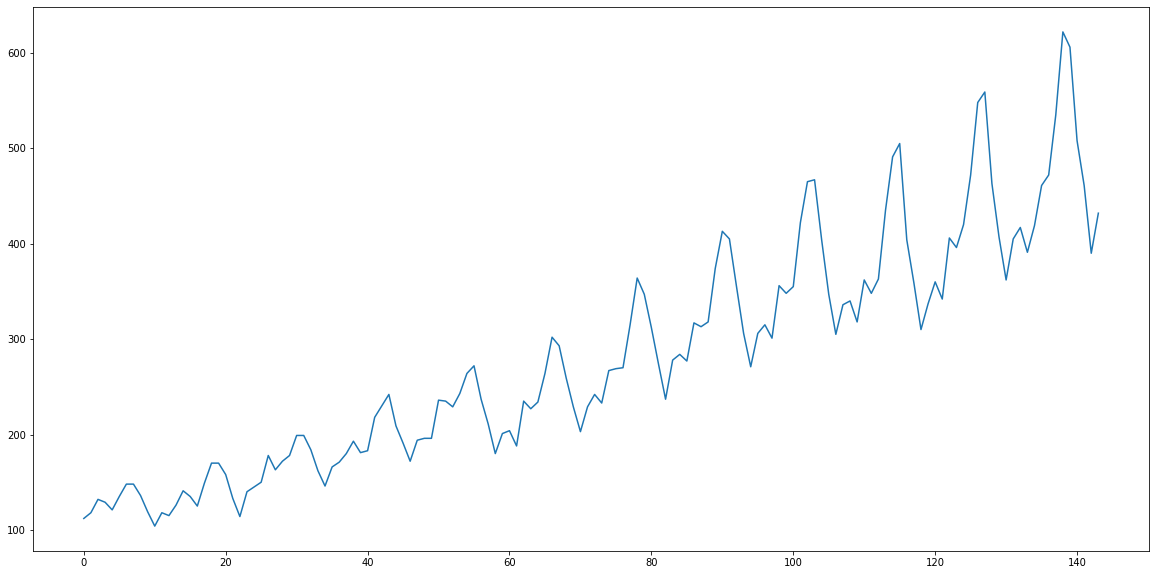

In [13]:
plt.figure(figsize=(20,10))
plt.plot(df['value'])

## 2. Crea en una gráfica la variable original + su media obtenida mediante una rolling window comparando el valor de seasonality obtenido en el apartado anterior

In [27]:
df['MA'] = df['value'].rolling(5).mean()
df

,date,value,MA
0,1949-01-01,112,NaN
1,1949-02-01,118,NaN
2,1949-03-01,132,NaN
3,1949-04-01,129,NaN
4,1949-05-01,121,122.4
...,...,...,...
139,1960-08-01,606,539.2
140,1960-09-01,508,548.6
141,1960-10-01,461,546.4
142,1960-11-01,390,517.4


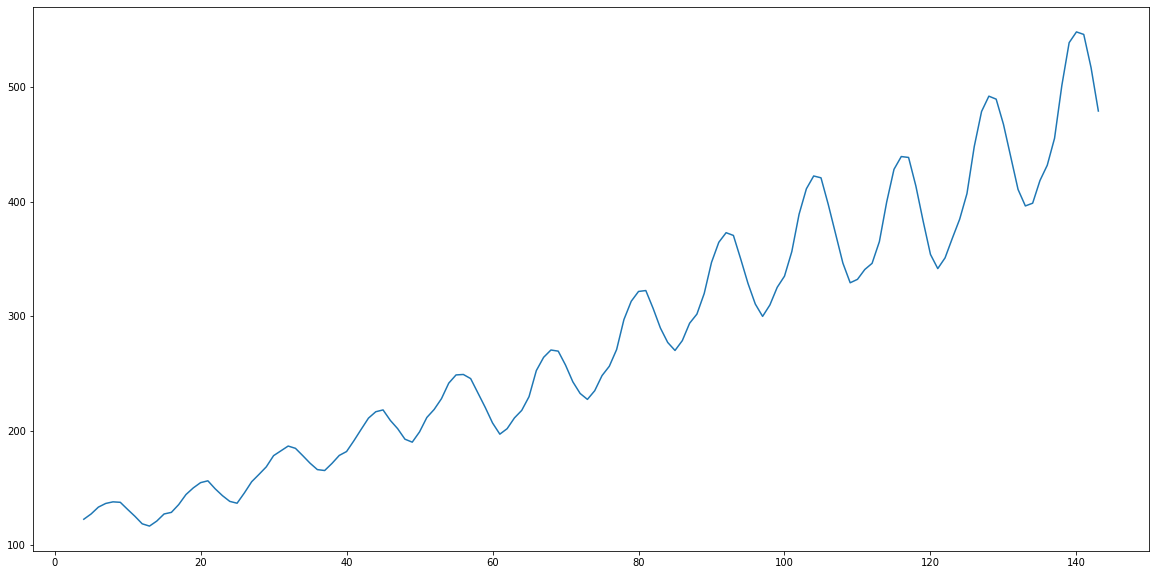

In [16]:
plt.figure(figsize=(20,10))
plt.plot(df['MA'])

## 3. Comprueba de manera estadística si la serie es o no stationary.

In [17]:
from statsmodels.tsa.stattools import adfuller

adfuller(df['value'].values)[1]

0.9918802434376409

## 4. Aplica una transformación logarítmica

In [18]:
df['value']

0      112
1      118
2      132
3      129
4      121
      ... 
139    606
140    508
141    461
142    390
143    432
Name: value, Length: 144, dtype: int64

In [19]:
np.log(df['value'])

0      4.718499
1      4.770685
2      4.882802
3      4.859812
4      4.795791
         ...   
139    6.406880
140    6.230481
141    6.133398
142    5.966147
143    6.068426
Name: value, Length: 144, dtype: float64

In [28]:
df['value'] = np.log(df['value'])
df.set_index(df['date'], inplace=True, drop=True)

,date,value,MA
date,,,
1949-01-01,1949-01-01,4.718499,NaN
1949-02-01,1949-02-01,4.770685,NaN
1949-03-01,1949-03-01,4.882802,NaN
1949-04-01,1949-04-01,4.859812,NaN
1949-05-01,1949-05-01,4.795791,122.4


In [29]:
df.drop(columns=['MA','date'], inplace=True)
df.head()

,value
date,
1949-01-01,4.718499
1949-02-01,4.770685
1949-03-01,4.882802
1949-04-01,4.859812
1949-05-01,4.795791


## 5. Divide en train y test. Guarda 20 muestras para test.

In [30]:
len(df)

144

In [31]:
train = df.iloc[:124,]
test = df.iloc[124:,]

In [32]:
print(train.shape)
print(test.shape)

(124, 1)
(20, 1)


## 6. Crea tu primer modelo ARIMA

In [33]:
from pmdarima.arima import auto_arima, ARIMA

In [34]:
model = auto_arima(train,
                   start_p = 1,
                   start_q = 1,
                   max_p = 5,
                   max_q = 5,
                   max_d = 3,
                   trace=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-208.997, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-201.351, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-202.849, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-204.251, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-202.180, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-229.487, Time=0.32 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-204.379, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-228.871, Time=0.83 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.57 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.54 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-203.109, Time=0.18 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-229.535, Time=0.97 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-233.928, Time=0.73 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-214.822, Time=0.31 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=-

In [36]:
y_pred = model.predict(20)
y_pred

array([6.0368161 , 6.09683452, 6.0956222 , 6.12758822, 6.1137967 ,
       6.12184686, 6.12045233, 6.12803824, 6.13948423, 6.15131099,
       6.16557818, 6.1772066 , 6.18872037, 6.19854138, 6.208086  ,
       6.21755694, 6.22723767, 6.23737053, 6.24770219, 6.25822248])

## 7. Representa en una gráfica los datos de test y tus predicciones.

In [38]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(test.values, y_pred)

0.12657252410066783

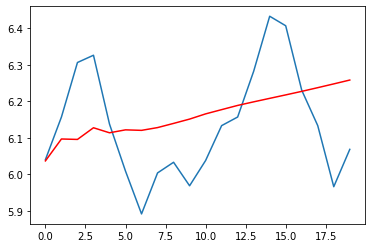

In [39]:
plt.plot(test.values)
plt.plot(y_pred, c='r');

In [40]:
model = auto_arima(train,
                   start_p = 1,
                   start_q = 1,
                   max_p = 5,
                   max_q = 5,
                   max_d = 3,
                   m = 12,
                   stationary=False,
                   trace=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=-409.479, Time=0.89 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-290.649, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-399.417, Time=0.91 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=-353.179, Time=0.43 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=-125.472, Time=0.02 sec
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=-411.631, Time=1.06 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=-384.170, Time=0.46 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=-409.714, Time=3.37 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=-405.268, Time=1.13 sec
 ARIMA(1,0,1)(1,1,2)[12] intercept   : AIC=-408.115, Time=2.65 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=-408.086, Time=0.70 sec
 ARIMA(2,0,1)(0,1,1)[12] intercept   : AIC=-410.728, Time=0.92 sec
 ARIMA(1,0,2)(0,1,1)[12] intercept   : AIC=-409.956, Time=1.43 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=-300.825, Time=0.24 sec
 ARIMA(0,0,2)(0,1,1

0.02702695363004102


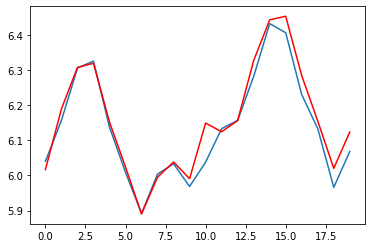

In [45]:
y_pred = model.predict(20)

print(mean_absolute_error(test.values, y_pred))

plt.plot(test.values)
plt.plot(y_pred, c='r');

In [47]:
np.exp(y_pred)

array([410.22123252, 487.71717651, 548.91865685, 555.51774948,
       469.6662799 , 413.22904447, 361.52629299, 401.45970978,
       419.23047944, 399.70649682, 468.41487477, 456.97303402,
       471.77091817, 559.75766695, 628.71693543, 635.18368843,
       536.20241671, 471.14208207, 411.71173943, 456.7202892 ])

## 8. Prueba otros modelos, a ver qué performance presentan.

In [48]:
for i in range(12, 0, -1):
    df['t-'+str(i)] = df.value.shift(i)

df.dropna(inplace=True)
df

,value,t-12,t-11,t-10,t-9,t-8,t-7,t-6,t-5,t-4,t-3,t-2,t-1
date,,,,,,,,,,,,,
1950-01-01,4.744932,4.718499,4.770685,4.882802,4.859812,4.795791,4.905275,4.997212,4.997212,4.912655,4.779123,4.644391,4.770685
1950-02-01,4.836282,4.770685,4.882802,4.859812,4.795791,4.905275,4.997212,4.997212,4.912655,4.779123,4.644391,4.770685,4.744932
1950-03-01,4.948760,4.882802,4.859812,4.795791,4.905275,4.997212,4.997212,4.912655,4.779123,4.644391,4.770685,4.744932,4.836282
1950-04-01,4.905275,4.859812,4.795791,4.905275,4.997212,4.997212,4.912655,4.779123,4.644391,4.770685,4.744932,4.836282,4.948760
1950-05-01,4.828314,4.795791,4.905275,4.997212,4.997212,4.912655,4.779123,4.644391,4.770685,4.744932,4.836282,4.948760,4.905275
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1960-08-01,6.406880,6.326149,6.137727,6.008813,5.891644,6.003887,6.033086,5.968708,6.037871,6.133398,6.156979,6.282267,6.432940
1960-09-01,6.230481,6.137727,6.008813,5.891644,6.003887,6.033086,5.968708,6.037871,6.133398,6.156979,6.282267,6.432940,6.406880
1960-10-01,6.133398,6.008813,5.891644,6.003887,6.033086,5.968708,6.037871,6.133398,6.156979,6.282267,6.432940,6.406880,6.230481


In [49]:
X = df.drop(columns='value')
y = df['value']

In [50]:
len(X)

132

In [52]:
X_train = X.iloc[:112,]
X_test = X.iloc[112:,]
y_train = y[:112]
y_test = y[112:]

In [53]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(112, 12)
(20, 12)
(112,)
(20,)


0.08069204066923205


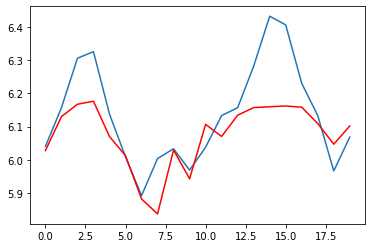

In [54]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(max_depth=5)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(mean_absolute_error(y_test, y_pred))

plt.plot(test.values)
plt.plot(y_pred, c='r');